In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve


In [2]:
df = pd.read_csv('./data/merged_weather_tweets.csv')
df.head()

,Unnamed: 0,datetime,text,regex_clean_tweets,lemmed_tweet,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,...,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain,outage
0,0,2012-10-06 13:00:00,Partial power outage at #MediaLoft That's...,Partial power outage MediaLoft That twice week...,Partial power outage MediaLoft That twice week...,61.55,56.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1,2012-10-12 01:00:00,"Um, can someone call ConEd , there's a power...",Um someone call ConEd power outage Bronx Sourc...,Um someone call ConEd power outage Bronx Sourc...,59.48,260.0,15,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,2,2012-10-20 23:00:00,Power outage took over my entire block as s...,Power outage took entire block soon loaded Con...,Power outage took entire block soon loaded Con...,65.86,170.0,11,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,3,2012-10-26 15:00:00,Mayor: A major concern given this type of stor...,Mayor A major concern given type storm possibi...,Mayor A major concern given type storm possibi...,59.88,40.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,4,2012-10-26 15:00:00,A major concern given this storm is the possib...,A major concern given storm possibility prolon...,A major concern given storm possibility prolon...,59.88,40.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [3]:
df.shape

(45545, 45)

In [4]:
# drop the Unnamed and lemmed_tweet columns
df.drop(columns=['Unnamed: 0', 'lemmed_tweet'], 
        inplace=True)

In [5]:
df.shape

(45545, 43)

In [6]:
df.columns

Index(['datetime', 'text', 'regex_clean_tweets', 'temperature_f',
       'wind_dir_degrees', 'wind_speed_mph', 'broken clouds', 'drizzle',
       'dust', 'few clouds', 'fog', 'freezing rain', 'haze',
       'heavy intensity drizzle', 'heavy intensity rain', 'heavy snow',
       'heavy thunderstorm', 'light intensity drizzle',
       'light intensity shower rain', 'light rain', 'light rain and snow',
       'light snow', 'mist', 'moderate rain', 'overcast clouds',
       'proximity thunderstorm', 'proximity thunderstorm with drizzle',
       'proximity thunderstorm with rain', 'sand', 'sand/dust whirls',
       'scattered clouds', 'shower rain', 'sky is clear', 'smoke', 'snow',
       'squalls', 'thunderstorm', 'thunderstorm with heavy rain',
       'thunderstorm with light drizzle', 'thunderstorm with light rain',
       'thunderstorm with rain', 'very heavy rain', 'outage'],
      dtype='object')

In [7]:
# extracting all the features except the target vector 
# we need this later for the PCA
features = df.columns[2:40]

In [8]:
features

Index(['regex_clean_tweets', 'temperature_f', 'wind_dir_degrees',
       'wind_speed_mph', 'broken clouds', 'drizzle', 'dust', 'few clouds',
       'fog', 'freezing rain', 'haze', 'heavy intensity drizzle',
       'heavy intensity rain', 'heavy snow', 'heavy thunderstorm',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light rain and snow', 'light snow', 'mist', 'moderate rain',
       'overcast clouds', 'proximity thunderstorm',
       'proximity thunderstorm with drizzle',
       'proximity thunderstorm with rain', 'sand', 'sand/dust whirls',
       'scattered clouds', 'shower rain', 'sky is clear', 'smoke', 'snow',
       'squalls', 'thunderstorm', 'thunderstorm with heavy rain',
       'thunderstorm with light drizzle', 'thunderstorm with light rain'],
      dtype='object')

In [9]:
# creating our X and y vectors
X = df['regex_clean_tweets']
#weather = df[features]
y = df['outage']

In [10]:
#X = text.join(weather).head()

In [11]:
#X.shape

In [12]:
#weather.shape

## Baseline Score

In [13]:
y.value_counts(normalize=True)

0.0    0.987968
1.0    0.012032
Name: outage, dtype: float64

In [14]:
y.value_counts()

0.0    44997
1.0      548
Name: outage, dtype: int64

We have a highly imbalanced target vector. This is not unexpected given that power outages are infrequent. 

## Model with only Text Data

In [15]:
# what the class weight parameter in the estimator
# does under the hood
#len(y) / (2 * np.bincount(y))

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                   random_state=42)

In [18]:
X_train.shape

(34158,)

In [ ]:
X_test.shape

(11387,)

In [ ]:
def classifier(X, y, estimator, random_state=42):
    
    '''
    A function that takes 4 arguments: an n x 1 predictor vector, 
    an n x 1 target vector, an estimator, and sets a random state.
    
    It trains tests splits the data, uses a pipeline, performs a
    grid search for optimal hyperparameters, calculates evaluation
    metrics and returns a classification report and an roc-auc curve.
    '''
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = .40, 
                                                        stratify=y,
                                                       random_state=42)
    
    
    pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('clf', estimator)
    ])

    pipe_params = {
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tvec__max_features': [500, 1000, 2000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [1.0, 0.8, 0.6]
    }

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)

    gs.fit(X_train, y_train)

    print(f'The Accuracy score is: {round(gs.score(X_train, y_train), 2)}')

    print(gs.best_params_)
    print(f'The cross_val_score is: {round(gs.best_score_, 2)}')
    #y_predpr_lr = gs.best_estimator_.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, gs.best_estimator_.predict(X_test)).ravel()



    accuracy = round((tn + tp) / (tn + fp + fn + tp), 2)
    misclassification = round((1 - accuracy), 2)
    sensitivity = round((tp) / (tp + fn), 2)
    specificity = round((tn) / (tn + fp), 2)
    precision = round((tp) / (tp + fp), 2)

    print(f'The Accuracy is: {accuracy}')
    print(f'The Missclassification Rate is: {misclassification}')
    print(f'The Sensitivity/Recall is: {sensitivity}')
    print(f'The Specificity is: {specificity}')
    print(f'The Precision is: {precision}')


    fpr_clf, tpr_clf, _ = roc_curve(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    plt.figure(figsize = (10, 7))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_clf, tpr_clf, lw=3, label='The ROC curve (area = {:0.2f})'.format(roc_auc_clf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (Power Outage Related Tweets)', fontsize=18)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    print(classification_report(y_test, gs.best_estimator_.predict(X_test)))


The Accuracy score is: 0.98
{'tvec__max_df': 0.8, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
The cross_val_score is: 0.97
The Accuracy is: 0.97
The Missclassification Rate is: 0.03
The Sensitivity/Recall is: 0.29
The Specificity is: 0.98
The Precision is: 0.16
             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99     17999
        1.0       0.16      0.29      0.21       219

avg / total       0.98      0.97      0.98     18218



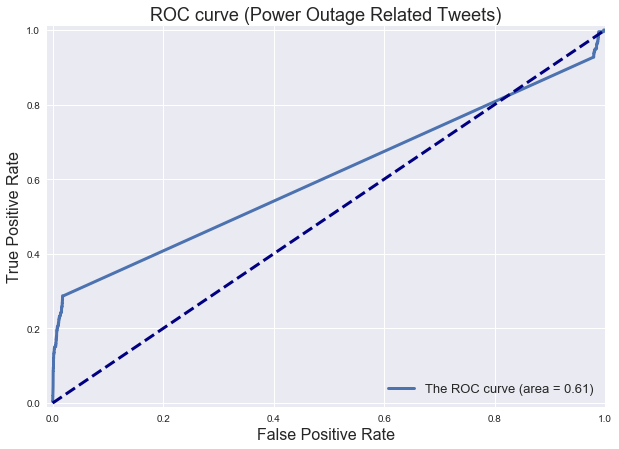

In [ ]:
classifier(X, y, 
           LogisticRegression(class_weight={1:107}), 
           random_state=42)

In [ ]:
classifier(X, y, 
           SVC(class_weight={1: 107}, probability=True), 
           random_state=42)

In [ ]:
# probs_y = lr.predict_proba(X_test_vec)#[:, 1]

In [ ]:
# y_test_pr = probs_y[:, 1]

In [ ]:
# y_train_pr = lr.predict_proba(X_train_tvec)[:, 1]

In [ ]:
# ### Predict test_y values and probabilities based on fitted logistic regression model

# pred_y=lr.predict(X_test_vec) 

# probs_y=lr.predict_proba(X_test_vec) 
#   # probs_y is a 2-D array of probability of being labeled as 0 (first 
#   # column of array) vs 1 (2nd column in array)

# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
#    #retrieve probability of being 1(in second column of probs_y)

# #pr_auc = metrics.auc(recall, precision)

# plt.figure(figsize=(10, 7))
# plt.title("Precision-Recall vs Threshold Chart")
# plt.plot(thresholds, precision[: -1], "b--", label="Precision")
# plt.plot(thresholds, recall[: -1], "r--", label="Recall")
# plt.ylabel("Precision, Recall")
# plt.xlabel("Threshold")
# plt.legend(loc="lower left")
# plt.ylim([0,1])

In [ ]:
# threshold, upper, lower = 0.95, 1, 0

In [ ]:
# y_train_scores = np.where(y_train_pr > threshold, upper, lower)

In [ ]:
# y_test_scores = np.where(y_test_pr > threshold, upper, lower)

In [ ]:
# returns a bar plot of some evaluation metrics for the two models

objects = ('Recall (wSVC)', 'Precision (wSVC)', 'Accuracy (wSVC)', 
           'Recall (wlr)', 'Precision (wlr)', 'Accuracy (wlr)')
y_pos = np.arange(len(objects))
performance = [36, 10, 95, 29, 16, 97] # scores from the calculations above
 
plt.figure(figsize=(10, 6))
    
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('')
plt.xlabel('Score', fontsize=16)
plt.title('Calssification Metrics', fontsize=18)

plt.savefig('./images/metrics.png')

Reported in the barplot above are the recall, precision and accuracy scores from the two class weighted models. We employ class weights to address the high class imbalance in our data. 

The evaluation of our models are summarized thus:

- Using the `weighted Support Vector Classifier (wSVC)`, we obtain a better recall when compared to that from the `weighted Logistic Regression (wlr)`. 


- However, the trade-off between the recall and precision appears to be more pronounced for the `SVC` than the `lr`. 


- The `lr` has a better `f1 score` than that from the `SVC`. The `f1 score` can be interpreted as a weighted average of the precision and recall values, where an `f1 score` reaches its best value at 1 and worst value at 0. 